# Power predictor

### First run generate_TI_set.py, which will generate the simulated TI dataset. 

In [2]:
from data_filter import get_filtered_data
from util import get_dataframes, timestamp_to_datetime_index
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb


### Getting filtered datasets with Simulated TI

In [3]:
data = get_filtered_data(include_ti=True)

In [4]:
print(data.keys())
print(data['A01'].columns)
print(type(data['A01']))
print(len(data['A01']))


dict_keys(['A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'J01', 'J02', 'J03', 'J04', 'J05', 'K01', 'K02', 'K03', 'K04', 'K05', 'L01', 'L02', 'L03', 'L04', 'L05', 'T01', 'T02', 'T03', 'T04', 'T05'])
Index(['ActivePower', 'Pitch', 'GenRPM', 'WindSpeed', 'WindDirection',
       'YawAngle', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'TSR',
       'YawOffset'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
10128


In [5]:
testdata = get_dataframes(print_names=False)
testdata['simulated_ti'].shape

(11431, 68)

### Pearson correlation.

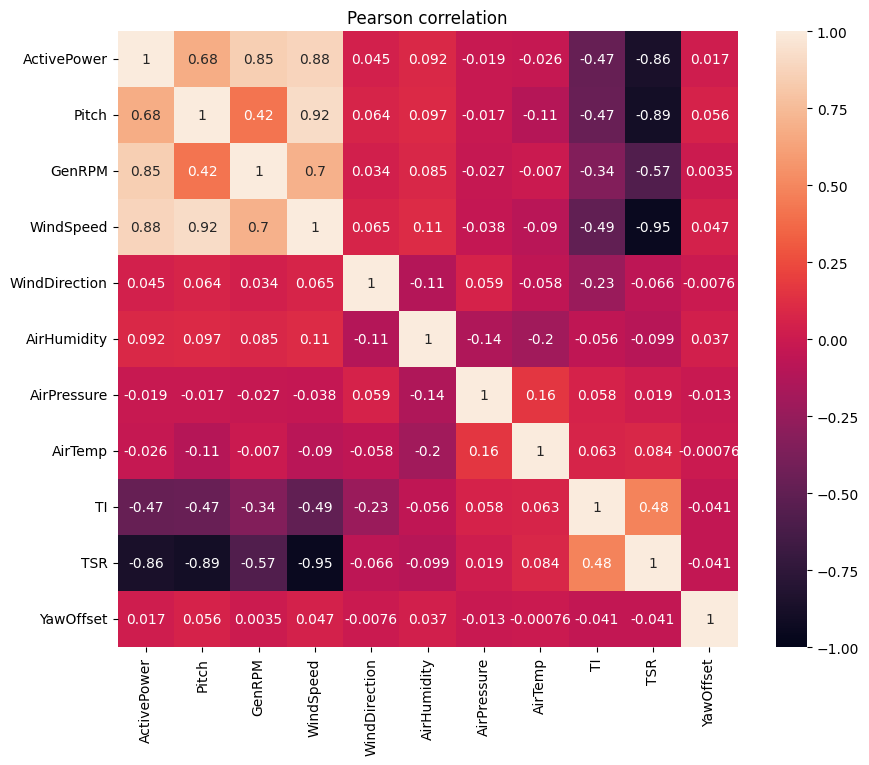

<Figure size 1500x600 with 0 Axes>

In [6]:
plt.rcParams["figure.figsize"] = (10, 8)
corrolation_sample = data['A04'][['ActivePower', 'Pitch', 'GenRPM', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'TSR', 'YawOffset']].sample(frac=0.1)
corrolation_matrix = corrolation_sample.corr(method="pearson", numeric_only = True)

ax = sb.heatmap(corrolation_matrix, vmin = -1, vmax = 1, annot = True)
plt.figure(figsize=(15,6))
ax.set_title('Pearson correlation', )
plt.show()


### XGBoost model training

In [9]:
from sklearn.model_selection import train_test_split
#Dividing the training/dataset
test_data = {}
train_data = {}
for name, df_i in data.items():
    test, train = train_test_split(df_i, test_size=0.2)
    test_data[name] = test
    train_data[name] = train

Generating hybrid regressors

In [13]:
from xgboost import XGBRegressor
from tqdm import tqdm
import time
included_features_hybrid = ['Pitch', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'TSR', 'YawOffset']
label = 'ActivePower'

for name, test_set in tqdm(test_data.items(), desc='Generating Hybrid Power Predictors (HPP)'):
    bst = XGBRegressor()
    bst.fit(test_set[included_features_hybrid], test_set[label])
    bst.save_model(f'./regressors/hybrid/{name}_HPP.json')

100%|██████████| 67/67 [00:04<00:00, 14.28it/s]


Generating standard regressors

In [14]:
included_features_standard = ['Pitch', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TSR', 'YawOffset'] #Only missing simulated TI
label = 'ActivePower'

for name, test_set in tqdm(test_data.items(), desc='Generating Standard Power Predictors (SPP)'):
    bst = XGBRegressor()
    bst.fit(test_set[included_features_hybrid], test_set[label])
    bst.save_model(f'./regressors/standard/{name}_SPP.json')

Generating Standard Power Predictors (SPP): 100%|██████████| 67/67 [00:04<00:00, 13.74it/s]
